<a href="https://colab.research.google.com/github/solobala/CVML10/blob/main/CVML10_%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_%D1%81%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carvana Image Masking Challenge

https://www.kaggle.com/c/carvana-image-masking-challenge

In [1]:
%matplotlib inline
import cv2
import imageio
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

print(cv2.__version__)
print(imageio.__version__)
print(tf.__version__)

4.8.0
2.31.6
2.14.0


## Загружаем исходные изображения

In [31]:
# Загрузила данные из датасета Kaggle
from zipfile import ZipFile
with ZipFile('/content/train.zip', 'r') as zip_file:
     zip_file.extractall(path='/content/data/carvana')

In [32]:
with ZipFile('/content/train_masks.zip', 'r') as zip_file:
     zip_file.extractall(path='/content/data/carvana')

In [33]:
from glob import glob

IMG_HEIGHT = 320
IMG_WIDTH = 480
# Здесь в списке сохраняются пути к файлам заданногог типа в заданной директории
train_img_paths = sorted(glob('data/carvana/train/*.jpg'))
train_mask_paths = sorted(glob('data/carvana/train_masks/*.gif'))


In [57]:
def load_image(path):
    # используем imageio, тк cv2
    # не поддерживает загрузку .gif
    img = imageio.v2.imread(path)
    return cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

def load_mask(path):
    img = imageio.v2.imread(path)
    # Этой инструкции в лекции не было, пришлось добавить, чтобы заработало
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

def binarise(img):
    # У нас 2 типа пикселей - изображение (-1) и фон (1). Делаем разметку изображений
    thr, result = cv2.threshold(img, -1, 1, cv2.THRESH_OTSU)
    return result

In [58]:
# Это массив трансформированных изображений для тренировки
train_imgs = np.array(
    [load_image(path) for path in train_img_paths])


In [60]:
# Это массив разметки для тренировки
train_masks = np.array(
    [binarise(load_mask(path)) for path in train_mask_paths])

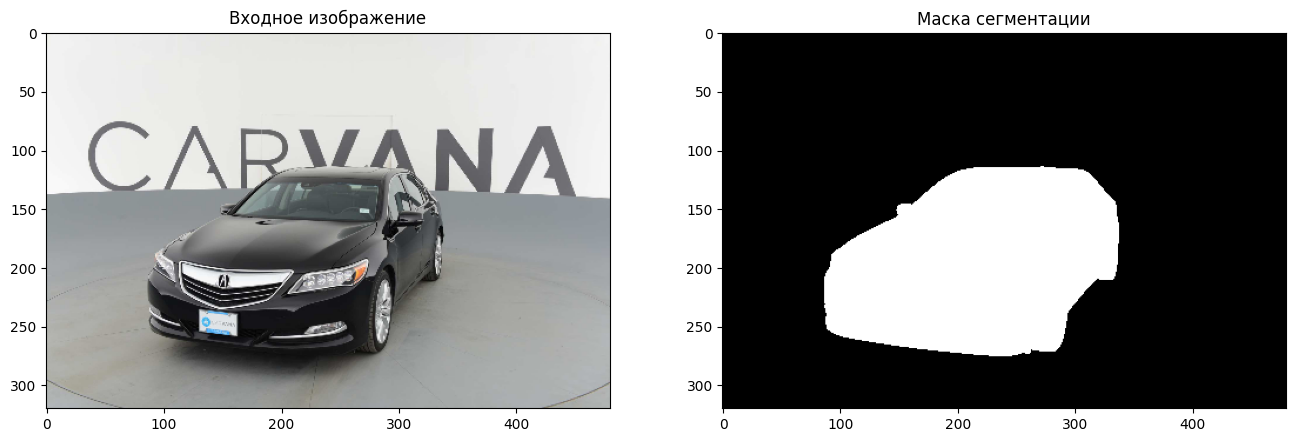

In [61]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title('Входное изображение')
plt.imshow(train_imgs[1]);

plt.subplot(1, 2, 2)
plt.title('Маска сегментации')
plt.imshow(train_masks[1], cmap='gray');

## Инициализируем архитектуру U-Net

In [62]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate

def create_unet(height, width):
    inputs = Input((height, width, 3))

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5),
                       conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6),
                       conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return tf.keras.Model(inputs=[inputs], outputs=[conv10])

In [63]:
model = create_unet(IMG_HEIGHT, IMG_WIDTH)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 320, 480, 3)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 320, 480, 32)         896       ['input_3[0][0]']             
                                                                                                  
 conv2d_39 (Conv2D)          (None, 320, 480, 32)         9248      ['conv2d_38[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 160, 240, 32)         0         ['conv2d_39[0][0]']           
 g2D)                                                                                       

## Задаем функцию потерь

In [64]:
SMOOTH = 1.

def dice_coef(y_true, y_pred):
    y_pred_f = tf.reshape(y_pred, [-1]) # то же что и flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_true_f = tf.cast(y_true_f, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + SMOOTH) / (tf.reduce_sum(y_true_f + y_pred_f) + SMOOTH)

def bce_dice_loss(y_true, y_pred):
    # Это кастомная ф-я потерьЮ которая минимизирует binary crossentropy ( ошибку классификатора) и одновременно максимизирует IOU ( dice_coef)
    return 0.2 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

## Запускаем процесс обучения

In [65]:
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),
              bce_dice_loss,
              metrics=[tf.keras.losses.binary_crossentropy, dice_coef])

In [66]:
model.fit(train_imgs, train_masks, batch_size=4, epochs=1)

1272/1272 [==============================] - 13808s 11s/step - loss: -0.9164 - binary_crossentropy: 0.1152 - dice_coef: 0.9394


## Предсказание модели

In [67]:
test_paths = sorted(glob('data/carvana/test/*.jpg'))

def test_img_generator(test_paths):
    for path in test_paths:
        yield np.array([load_image(path)])

In [68]:
test_iter = test_img_generator(test_paths)
pred = model.predict(test_iter)

7/7 [==============================] - 6s 765ms/step


## Визуализируем результат на тестовом семпле

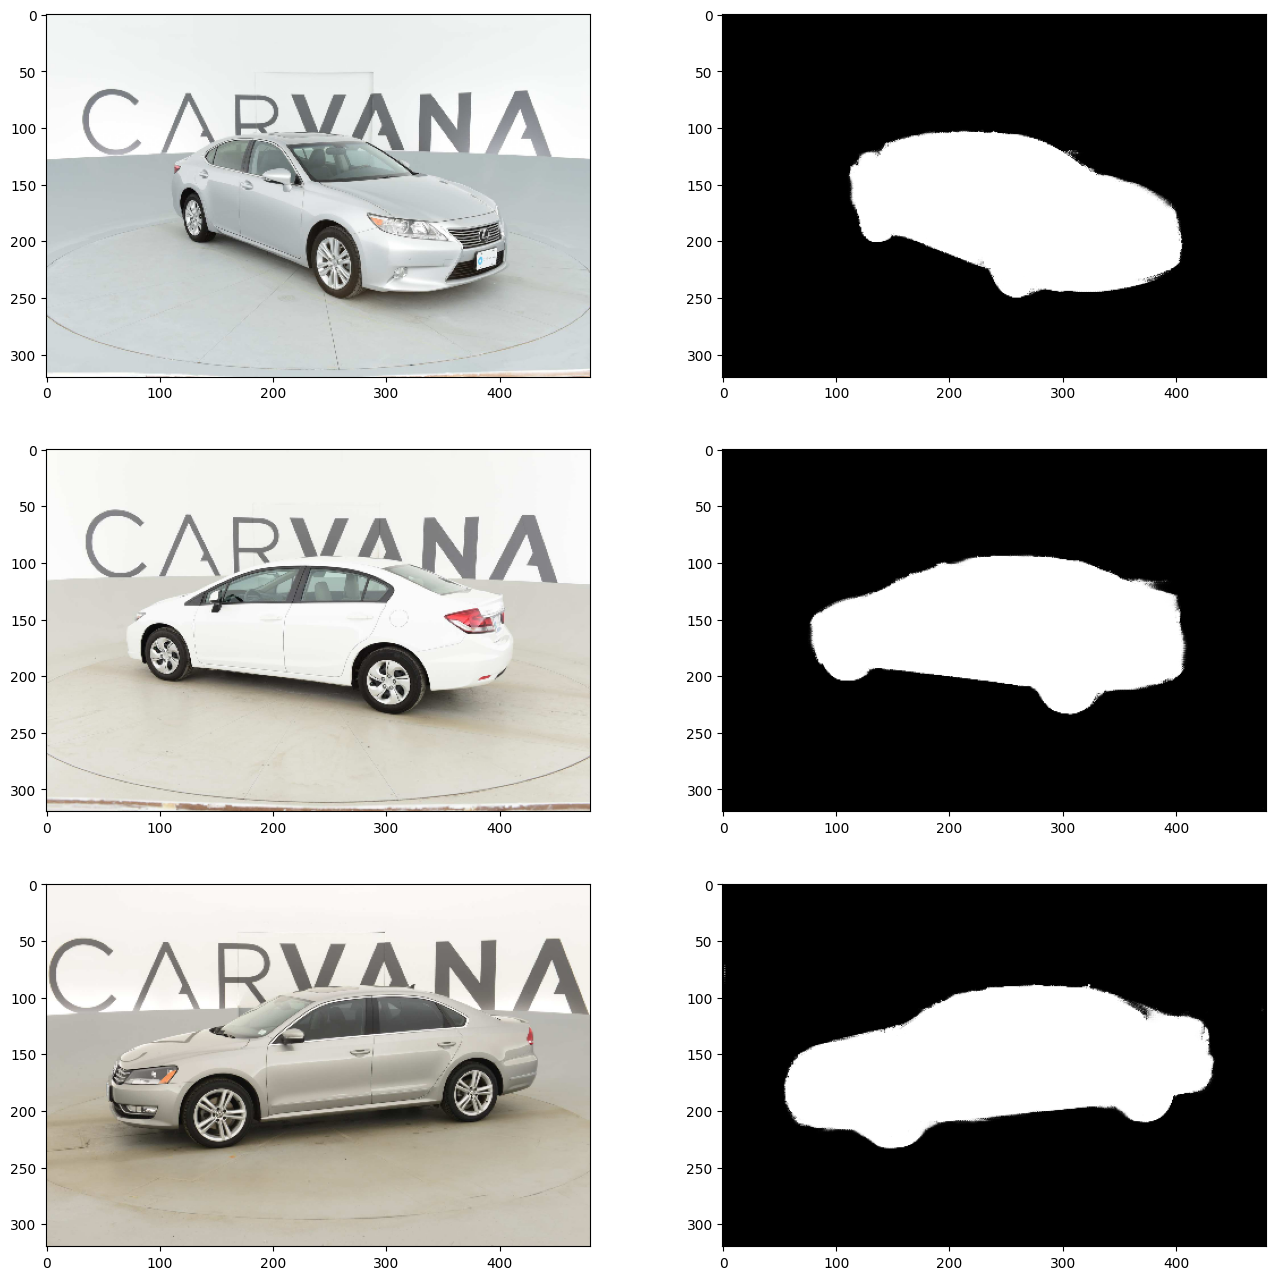

In [69]:
SHOW_SAMPLES = min(len(pred), 3)

fig = plt.figure(0, figsize=(16, 16))

for i in range(SHOW_SAMPLES):
    plt.subplot(SHOW_SAMPLES, 2, 2*i+1)
    plt.imshow(load_image(test_paths[i]))
    plt.subplot(SHOW_SAMPLES, 2, 2*i+2)
    plt.imshow(pred[i], cmap='gray')